In [ ]:
'''
Code used to set limits on subhalo populations.


'''

In [6]:
# load packages and functions
## plotting packages

import sys, os, time, fileinput
import numpy as np
import math as math 
from scipy.stats import maxwell, rv_histogram
from scipy.integrate import quad, dblquad
from scipy.special import erf
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import emcee

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors

plt.style.use('default') 

rcParams.update({'figure.autolayout': True})
plt.rc('font', family='serif')
mpl.mathtext.fontset : 'dejavusans'
    
mpl.rcParams['text.usetex'] = True

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['text.usetex'] = True

/tmp/ipykernel_1177/1597642725.py:34: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'png')


In [7]:
# input parameters

## perturber mass (M_sol)
log_m = float(3)
str_log_m = str.format('{0:.3f}',log_m)
m = 10**float(str_log_m)

## scale radius 
log_rs = float(-1) # NFW scale radius (pc)
str_log_rs = str.format('{0:.3f}',log_rs)

## concentration
log_c = float(0) # NFW concentration
str_log_c = str.format('{0:.3f}',log_c)

## halo fraction
log_f = float(0.2) # halo fraction [setting max number of time steps]
f = 10**log_f
str_log_f = str.format('{0:.3f}',log_f)

# threshold fractional energy injection defining p_max
log_eps = float(-2)  
energy_fraction = 10**log_eps
str_log_eps = str.format('{0:.2f}',log_eps)

# ------------------------
## approximate number of encounters
log_K = 4    # log number of samples
str_log_K = str.format('{0:.2f}',log_K)
K = int(10**log_K)
# ------------------------
## list of a0-values
bin_scale = 'log'

log_alow = float(-5)
str_log_alow = str.format('{0:.3f}',log_alow)
log_ahigh = float(2)
str_log_ahigh = str.format('{0:.3f}',log_ahigh)
step_size = float(0.04) # number of bins
str_step_size = str(step_size)
#str_step_size = str.format('{0:.3f}',step_size)

log_alow_offset = float(0)
str_log_alow_offset = str.format('{0:.3f}',log_alow_offset)
log_ahigh_offset = float(0)
str_log_ahigh_offset = str.format('{0:.3f}',log_ahigh_offset)

# eDR3 Data Version: Specify R_chance_align and separation cut to generate M_data
R_chance_align = float(0.1)
str_R_chance_align = str(R_chance_align)

scut = float(1)
str_scut = str(scut)

In [8]:
## Conversion Factors:
kg_g = 1E-3
Msolar_kg = 5.02785E-31 # Msolar/kg
pc_m = 3.24078E-17 # pc/m
Gyr_yr = pow(10,-9) # Gyr/yr
yr_s = 3.17098E-8 # yr/s
km_m = 1/1000 # km/m
kg_GeV = 1.78266E-27 # [kg/(GeV/c**2)]
m_cm = pow(10,-2) # m/cm
pc_AU = 4.84814e-6 # pc/AU
AU_pc = 206265  # AU/pc

#-------------------------
## fixed parameters 
#m1 = 0.5 # mass of primary (M_sol)
#m2 = 0.5 # mass of secondary (M_sol)
v0 = 240 # circular velocity (km/s) 
vesc = 533 # local escape velocity (km/s)
T = 10 # evolution time (Gyr)
#rho = 0.009 # Local DM Density (M_sol / pc**3) [Yoo]
rho_pdg = 0.39 # Local DM Density (GeV / cm3)
rho = 0.39 * (Msolar_kg) * (kg_GeV) * (pc_m)**(-3) * (m_cm)**(-3) #[Ed]


## constants
G = 4.30091e-3   # Grav Constant ([pc (M_solar)^-1 (km/s)**2])

In [9]:
## set up maximum impact parameter and time steps

### Compute the average inverse velocity for the truncated velocity profile

def v_theta_(cos_theta,v,vesc):
    return -v*cos_theta + np.sqrt(v*v*cos_theta*cos_theta + (vesc*vesc - v*v))

def fv_no_vesc_(v, sigma):
    return v*v*np.exp(-v*v / 4 / sigma / sigma)

def dfv_dcos_theta_eff_(v_theta,sigma):
    return (1/4) * (-2 * v_theta * np.exp( - v_theta * v_theta / sigma / sigma ) 
                 + np.sqrt(np.pi) * sigma * erf(v_theta / sigma) ) 

def inv_v_avg_(sigma,vesc,normalization):
    v_avg_eff = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma) / v, 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )
    return v_avg_eff / normalization

sigma = v0/math.sqrt(2)/math.sqrt(2)
normalization = ( dblquad(lambda cos_theta, v: 
                                     fv_no_vesc_(v, sigma) * dfv_dcos_theta_eff_(v_theta_(cos_theta,v/2,vesc),sigma), 0, 2*vesc, 
                                     lambda v: 0, lambda v: 1)[0] )
inv_v_avg = inv_v_avg_(sigma,vesc,normalization)

### max impact parameter when the fractional energy injection falls below energy_fraction
def p_max_(a,m,M,inv_v_avg,f,energy_fraction): 
    bar_C = 2*G*m * 2*G*m / 2 * inv_v_avg
    E = G * M / 2 / a
    inv_factor = np.pi * (f * rho * T / m) * bar_C / E
    bar_delta_Eps_val = inv_factor**(-1) * energy_fraction
    #if m >= 10:
    #    return a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc
    #else:
    #    return (m/10)**(1/2) * a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc
    return a * np.sqrt(1 + 2 * bar_delta_Eps_val**(-1) * (1 + np.sqrt(1 + bar_delta_Eps_val))) # pc

### load number of time steps needed to evolve for the specified evolution time
def delta_t_(m,inv_v_avg,f,R):    # length of time step in Gyr
    delta_t_val = m / (f * rho * np.pi * R**2) * inv_v_avg
    delta_t_val_Gyr = delta_t_val * ( (km_m) / (pc_m) ) * ( (Gyr_yr) * (yr_s) ) 
    return delta_t_val_Gyr  # Gyr

p_max = p_max_(1,m,1,inv_v_avg,1,energy_fraction) # p_max value   # p_max value 
delta_t = delta_t_(m,inv_v_avg,f,p_max)    # delta_t value
N = int(T / delta_t)    # number of time steps

# ------------------------------------------------------

# load samples
## parameters
N_enc = int(K*N) # number of samples
R = p_max   # maximum impact parameter (pc)

In [10]:
from numpy.random import binomial

# ----------------------------------------
## Load energy injection rate data
sorted_dir = 'sorted_data/' +str_log_m+'_'+str_log_rs+'_'+str_log_c+'_'+str_log_f+'_'+str_log_eps+'_'+str_log_K
file_name = 'hists_'+str_log_m+'_'+str_log_rs+'_'+str_log_c+'_'+str_log_f+'_'+str_log_eps+'_'+str_log_K+'_'+bin_scale+'_'+str_log_alow+'_'+str_log_ahigh+'_'+str_step_size+'_'+str_log_alow_offset+'_'+str_log_ahigh_offset

## Load energy injection rate data (DR2 for higher number of simulated binaries)
#sorted_dir = 'sorted_data/' +str_log_m+'_'+str_log_rs+'_'+str_log_c+'_'+str_log_f+'_'+str_log_eps+'_'+str_log_K
#file_name = 'hists_'+str_log_m+'_'+str_log_rs+'_'+str_log_c+'_'+str_log_f+'_'+str_log_eps+'_'+str_log_K+'_'+bin_scale+'_'+str_log_alow+'_'+str_log_ahigh+'_'+str_step_size+'_'+str_log_alow_offset+'_'+str_log_ahigh_offset


results_list = np.load(os.path.join(sorted_dir, file_name + '.npy'), allow_pickle = True)

# ----------------------------------------
## Load a-values and bins

# make the array of semimajor axis values
if bin_scale=='log': 
    bins = np.arange(log_alow+log_alow_offset,log_ahigh+log_ahigh_offset+step_size,step_size)  # bins
    bins = 10**bins
    mid = 0.5 * (bins[1:] + bins[:-1])

if bin_scale=='lin':
    alow=10**(log_alow + log_alow_offset)
    ahigh=10**(log_ahigh + log_ahigh_offset)

    Nbins = 180
    bins = np.arange(alow,ahigh,Nbins)  # bins
    mid = 0.5 * (bins[1:] + bins[:-1])

# ----------------------------------------
## Load catalog (updated for loading eDR3 halo subsample)
data_dir = 'data/' + 'halo_catalogs/'   # LOCAL loading

# ----------------------------------------
## Load catalog (updated for loading eDR3 halo subsample)

catalog_name = data_dir + 'catalog_data' + '_' + '1.0' + '_' + str_scut + '_cut_err' + '.npy'
catalog_sep_vec, catalog_dist_vec, catalog_delta_G_vec, catalog_R_chance_align_vec = np.load(catalog_name, allow_pickle = True)

# ----------------------------------------
# This block was added in the contamination version: 
# Contamination probability extrapolated to > 1 past the s > 1 pc.
# This requires us to modify the selection fct matrix AND the log-likelihood function
s_min = np.min(catalog_sep_vec)
s_max = np.max(catalog_sep_vec) # eDR3: note that s_max < scut <= 1 pc
n_min = np.where(bins <= s_min)[0][-1]
n_max = np.where(bins >= s_max)[0][0]

bins_data = bins[n_min:n_max+1]
mid_data = 0.5 * (bins_data[1:] + bins_data[:-1])

def selection_fct(theta,theta0):
    if theta < theta0:
        return 0
    else:
        return 1
    
selection_fct_vec = np.vectorize(selection_fct)

delta_G_mid = [0.5,1.5,2.5,3.5,5,7,9.5]
theta_cut_vals = [3.06481262,  3.26382633,  3.94047254,  4.61711977,  6.24903233,  9.55266057, 11.98062847]
#theta_cut_vals = np.ones(7) * 10
theta_cut_ = interp1d(delta_G_mid, theta_cut_vals, kind = 'linear', fill_value = 'extrapolate', assume_sorted = True)

catalog_theta0_vec = theta_cut_(catalog_delta_G_vec)
catalog_data = np.array(np.vstack((catalog_sep_vec, catalog_dist_vec, catalog_delta_G_vec, catalog_R_chance_align_vec, catalog_theta0_vec)))

theta_mat = np.outer( 1/catalog_data[1,:] , mid_data * AU_pc)   # \theta_ij = s_j / d_i
print(theta_mat[1000,:])
theta0_T = catalog_data[-1,:]    # \theta_0_i
theta0_mat = (np.ones(np.shape(theta_mat)).T * theta0_T).T   # (1 \times \theta_ij)
catalog_f_mat = selection_fct_vec(theta_mat,theta0_mat)    # f(\theta_mat / \theta_0_mat)
print(np.array([selection_fct(theta_mat[1000,n], theta0_mat[1000,n]) for n in range(len(theta_mat[3,:])) ] ) )
print(catalog_f_mat[1000,:])
print(len(catalog_f_mat[1000,:][catalog_f_mat[1000,:] == 0]))
print(catalog_R_chance_align_vec[5000])

[4.93040620e-01 5.40608290e-01 5.92765203e-01 6.49954120e-01
 7.12660521e-01 7.81416723e-01 8.56806399e-01 9.39469535e-01
 1.03010786e+00 1.12949081e+00 1.23846204e+00 1.35794663e+00
 1.48895887e+00 1.63261094e+00 1.79012229e+00 1.96283006e+00
 2.15220037e+00 2.35984078e+00 2.58751396e+00 2.83715264e+00
 3.11087601e+00 3.41100771e+00 3.74009558e+00 4.10093326e+00
 4.49658390e+00 4.93040620e+00 5.40608290e+00 5.92765203e+00
 6.49954120e+00 7.12660521e+00 7.81416723e+00 8.56806399e+00
 9.39469535e+00 1.03010786e+01 1.12949081e+01 1.23846204e+01
 1.35794663e+01 1.48895887e+01 1.63261094e+01 1.79012229e+01
 1.96283006e+01 2.15220037e+01 2.35984078e+01 2.58751396e+01
 2.83715264e+01 3.11087601e+01 3.41100771e+01 3.74009558e+01
 4.10093326e+01 4.49658390e+01 4.93040620e+01 5.40608290e+01
 5.92765203e+01 6.49954120e+01 7.12660521e+01 7.81416723e+01
 8.56806399e+01 9.39469535e+01 1.03010786e+02 1.12949081e+02
 1.23846204e+02 1.35794663e+02 1.48895887e+02 1.63261094e+02
 1.79012229e+02 1.962830

In [ ]:
#catalog_f_mat_vec = selection_fct_vec(theta_mat,theta0_mat)

In [ ]:
I, J = np.shape(theta_mat)
catalog_f_mat_2 = np.zeros([I,J])
for i in range(I):
    for j in range(J):
        catalog_f_mat_2[i,j] = selection_fct(theta_mat[i,j], theta0_mat[i,j])
        
catalog_f_mat == catalog_f_mat_2

In [ ]:
for n in range(100):
    selection_fct_vec(theta_mat,theta0_mat)

In [ ]:
catalog_f_mat_vec == catalog_f_mat

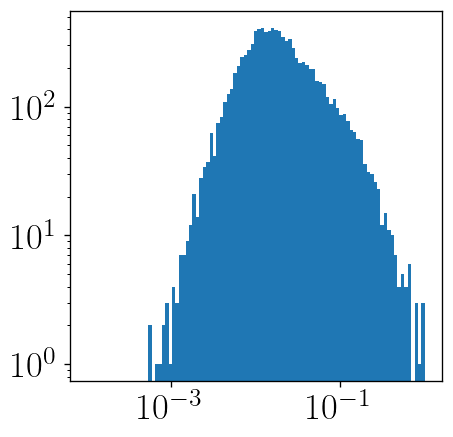

In [11]:
fig = plt.figure(figsize=(4, 4), dpi= 120)
ax = fig.add_subplot(111)

counts_test, bins_test, _ = ax.hist(catalog_sep_vec, bins = np.logspace(-4,0,100))
ax.set_xscale('log')
ax.set_yscale('log')

(0.0, 1.05)

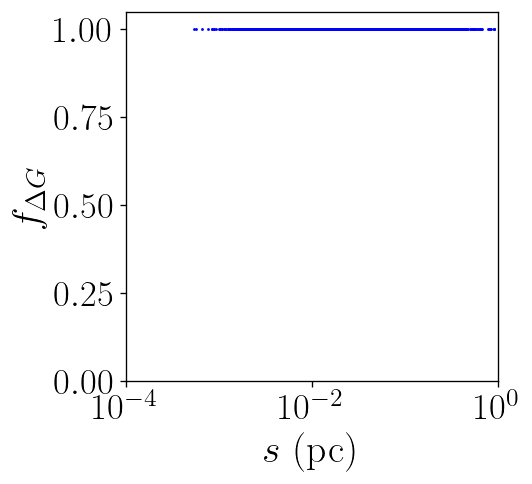

In [12]:
fig = plt.figure(figsize=(4, 4), dpi= 120)
ax = fig.add_subplot(111)

ax.scatter(catalog_sep_vec, selection_fct_vec(catalog_sep_vec * AU_pc / catalog_dist_vec, catalog_theta0_vec), s = 0.5, c = 'b', label = 'Data')
    
ax.set_xlabel('$s$ (pc)')
ax.set_ylabel('$f_{\\Delta G}$')
ax.set_xscale('log')
ax.set_xlim([10**-4,1])
ax.set_ylim([0,1.05])

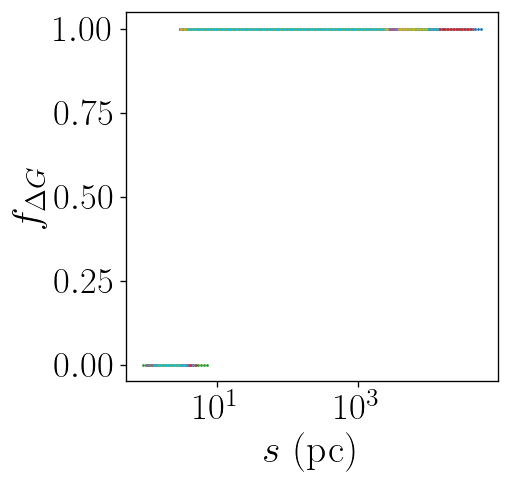

In [13]:
fig = plt.figure(figsize=(4, 4), dpi= 120)
ax = fig.add_subplot(111)

for n in range(70):
    ax.scatter(theta_mat[n,:], catalog_f_mat[n,:], s = 0.5, label = 'Data')
    
ax.set_xlabel('$s$ (pc)')
ax.set_ylabel('$f_{\\Delta G}$')
ax.set_xscale('log')

In [14]:
# ========================================

# Inputs
p0_bounds = [[0,3],[-3,3],[-3,log_f]]
power_law_index = 1.73
power_law_index_ca = -1

N_data = np.size(catalog_data[0,:])

# --------------------------------------------------

# load initial separation distribution (neglect normalization)
def dn0da_fct(a,l):
    return a**-l 

# evolve separation distribution to T ~ 10 Gyr
def phi(free_params):
    power_index = free_params[0]
    log_f = free_params[-1]
    f = 10**(log_f)

    # evolve histogram to T ~ 10 Gyr (depends on f)
    delta_t_val_f = delta_t_(m,inv_v_avg,f,p_max)    # delta_t value
    N_f = int(T / delta_t_val_f)    # number of time steps
    timestep = N_f - 1

    dn0da = dn0da_fct(mid,power_index)
    delta_a = np.diff(bins)      # bin spacing vector
    dnda = []                       # evolved histogram counts
    for i in range(len(mid)): 
        a0 = results_list[i][0]
        p_i = np.array([results_list[j][1][1][0][i,timestep] for j in range(len(mid))])        # survival probability 
        dnda = np.concatenate(([dnda, [np.sum(p_i * delta_a * dn0da)]]))
    return dnda / np.sum(np.diff(bins) * dnda) # notice we need to normalize since the rv_histogram.pdf is normalized

def phi_ca(free_params):
    power_index_ca = free_params[1]
    return dn0da_fct(mid, power_index_ca)

# see contamination_rate_fit local file for plot
#def contamination_probability_(s,parameter_vec):
#    polynomial_ = np.poly1d(parameter_vec)
#    polynomial_value = polynomial_(s)
#    return polynomial_value * np.heaviside(polynomial_value,0)

def theta_is_within_bounds(theta, theta_bounds):
    '''
    helper function for flat priors or restricted likelihoods. 
    theta: array of floats, e.g. [1, 2, 3]
    theta_bounds: array of constraints, e.g. [[0, None], [0, 3], [None, 5] 
    If there's a None in theta_bounds, the prior will be improper. 
    '''
    for i, param in enumerate(theta):
        this_min, this_max  = theta_bounds[i]
        
        if this_min is None:
            this_min = -np.inf
        if this_max is None:
            this_max = np.inf
        if not (this_min <= param < this_max):
            return False
    return True

# Contamination rate accounted for. Needed to restrict integration to data separations
# Otherwise, contamination probability would be greater than 1 and give an NAN log(denominator)
def log_likelihood(free_params, inputs):
    power_index = free_params[0]
    power_index_ca = free_params[1]
    log_f = free_params[-1]
    
    p0_bounds = inputs[-1]
    if theta_is_within_bounds(free_params, p0_bounds) == False:
        return -np.inf
    
    catalog_data = inputs[0]
    
    phi_vec = phi(free_params)
    phi_fct = rv_histogram([phi_vec,bins])
    
    numerator = phi_fct.pdf(catalog_data[0,:])
    Phi = np.diff(bins_data) * phi_vec[n_min:n_max] 
    denominator = np.dot(catalog_f_mat,Phi)
    
    prob = (1 - catalog_data[3,:]) * numerator / denominator
    
    phi_ca_vec = phi_ca(free_params)
    phi_ca_fct = rv_histogram([phi_ca_vec,bins])
    
    numerator_ca = phi_ca_fct.pdf(catalog_data[0,:])
    Phi_ca = np.diff(bins_data) * phi_ca_vec[n_min:n_max] 
    denominator_ca = np.dot(catalog_f_mat,Phi_ca)
    
    prob_ca = catalog_data[3,:] * numerator_ca / denominator_ca
    return np.sum(np.log(prob + prob_ca))

In [15]:
p0_bounds = [[0,3],[-3,3],[-3,0.2]]
free_params = [1.5,0,0]
inputs = [catalog_data,p0_bounds]

print(log_likelihood(free_params, inputs))

27463.912390618767


(1e-05, 100)

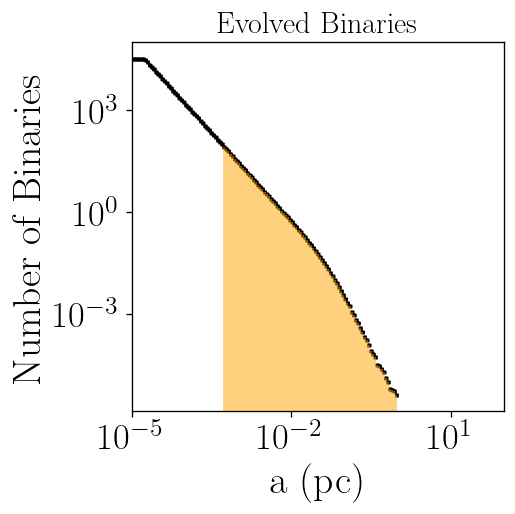

In [16]:
from scipy.stats import rv_histogram

# evolve histogram for specified timestep
log_f = -1
f = 0.1 # halo fraction [setting max number of time steps]
delta_t_val_f = delta_t_(m,v0,f,p_max)    # delta_t value
N_f = int(T / delta_t_val_f)    # number of time steps
timestep = int( (N_f - 1) / 1 )

l = 1.65

free_params = [1.73,-1,0]
phi_hist = phi(free_params)
hist_dist = rv_histogram([phi_hist,bins])

fig = plt.figure(figsize=(4, 4), dpi= 120)
ax = fig.add_subplot(111)

#n_a0 = np.where(mid >= 0.095)[0][0]
#a0, results_a0 = results_list[n_a0]

alist = np.logspace(-5,0,1000)
ax.bar(mid[n_min:n_max],phi_hist[n_min:n_max],width=np.diff(bins[n_min:n_max+1]),alpha=0.5, label = 'Normalized Histogram', color = 'orange')
ax.scatter(alist,hist_dist.pdf(alist), label  = 'rv_histogram', s = 1, marker = '_', c = 'k')

ax.set_xlabel('a (pc)')
ax.set_ylabel('Number of Binaries')
if bin_scale == 'log': ax.set_xscale('log')
if bin_scale == 'lin': ax.set_xscale('linear')
ax.set_yscale('log')
#ax.set_xlim([0.000245218616272841,1])
#ax.set_ylim([0.001,np.max(n) * 10])
ax.set_title('Evolved Binaries')

ax.set_xlim([10**-5, 10**2])

Text(0, 0.5, '$\\mathcal{L}$')

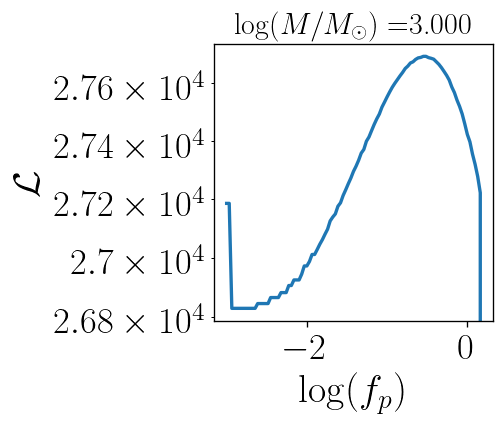

In [17]:
inputs = [catalog_data,p0_bounds]

p0_bounds = [[0,3],[-3,3],[-3,0.2]]
power_law_index = 1.5
power_law_index_ca = -1

log_fp_list = np.linspace(p0_bounds[-1][0],0.2,100)

log_likelihood_vec = []
for log_fp in log_fp_list:
    free_params_0 = [power_law_index, power_law_index_ca, log_fp]
    log_likelihood_val = log_likelihood(free_params_0, inputs)
    log_likelihood_vec = np.concatenate((log_likelihood_vec, [log_likelihood_val]))

fig = plt.figure(figsize=(3,3), dpi= 120)
ax = fig.add_subplot(111)
    
ax.plot(log_fp_list,log_likelihood_vec)
    
ax.set_xscale('linear')
ax.set_yscale('log')

ax.set_title('$\\log(M/M_{\\odot}) = $' + str_log_m)
ax.set_xlabel('$\\log(f_{p})$')
ax.set_ylabel('$\\mathcal{L}$')

In [18]:
free_params_0 = np.array([1.618096 ,-1, -1])  # obtained using no perturber broken power law fit (and eyeballing)
p0_bounds = [[0,3],[-3,1],[-3,0.2]]

ti = time.time()

res = optimize.minimize(lambda free_params, inputs: -log_likelihood(free_params, inputs),free_params_0,args = [catalog_data,p0_bounds],
                        method = 'Nelder-Mead', 
                        options={'maxiter':10,'maxfev':10,'adaptive':True,'xatol':0.0000001,'fatol':0.000000001})

calc_time_minimization = time.time() - ti

print('Finished Minimization Procedure: ' + str.format('{0:.2f}',calc_time_minimization/60) +  ' min')
print(res)

Finished Minimization Procedure: 0.00 min
 final_simplex: (array([[ 1.66918403, -1.02437128, -0.85939643],
       [ 1.69001138, -1.04444444, -0.91666667],
       [ 1.65347104, -1.00334362, -0.98070988],
       [ 1.71997612, -0.97962963, -0.94444444]]), array([-27695.53210244, -27691.11911937, -27684.96214054, -27684.23515206]))
           fun: -27695.532102441633
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 11
           nit: 5
        status: 1
       success: False
             x: array([ 1.66918403, -1.02437128, -0.85939643])


In [22]:
# ========================================
# Initializing the log posterior

def log_flat_prior(theta, theta_bounds):
    '''
    theta: array of parameters, e.g. [1, 2, 3]
    theta_bounds: array of the same length, but with a list of length
        two (lower and upper bounds) at each element. e.g.
        [[0, 2], [1, 3], [2, 6]]
    '''
    if theta_is_within_bounds(theta, theta_bounds):
        return 0
    else: 
        return -np.inf

def log_posterior(free_params, inputs):
    p0_bounds = inputs[-1]
    lnprior = log_flat_prior(theta = free_params, theta_bounds = p0_bounds)
    if np.isfinite(lnprior):
        lnlikelihood = log_likelihood(free_params,inputs)
    else:
        lnlikelihood = 0 
    return lnprior + lnlikelihood

# ========================================
# Inputs for emcee

nwalkers = int(32)
str_nwalkers = str(nwalkers)

burn = int(5)
str_burn = str(burn)

n_steps = int(10)
str_n_steps = str(n_steps)

# -----------------------------------------
# Running the emcee code

# Set initial walker positions
def get_good_p0_ball(p0, theta_bounds, nwalkers, r = 0.01):
    '''
    Utility function for initializing MCMC walkers. Returns walkers clustered around a 
    point p0 in parameter space, all of which fall within theta_bounds. 
    
    p0: point in parameter space that we think might have a high probability. e.g. [1, 2, 3]
    theta_bounds: the range of parameter space within which we'll allow the walkers to explore;
        we have flat priors within this region. E.g. [[0, 2], [1, 3], [2, 4]]
    nwalkers: int; number of walkers to initialize
    r: float. Decreasing this makes the walkers more and more clustered around p0
    '''
    num_good_p0 = 0

    ball_of_p0 = []
    while num_good_p0 < nwalkers:
        #suggested_p0 = p0 + np.array([r*j*np.random.randn() for j in p0])
        suggested_lambda = p0[0] + r*p0[0]*np.random.randn()
        suggested_lambda_ca = p0[1] + r*p0[1]*np.random.randn()
        suggested_log_fp = p0[-1] + r*np.random.randn()
        suggested_p0 = np.array([suggested_lambda,suggested_lambda_ca,suggested_log_fp])
        suggested_p0_prob = log_flat_prior(suggested_p0, theta_bounds = theta_bounds)
        if np.isfinite(suggested_p0_prob):
            ball_of_p0.append(suggested_p0)
            num_good_p0 += 1
    return ball_of_p0

file_name = ( 'emcee_splaw_' + str_log_m + '_' + str_log_K + '_'
             + bin_scale + '_' + str_log_alow + '_' + str_log_ahigh + '_' + str_step_size + '_'
             + str_log_alow_offset + '_' + str_log_ahigh_offset + '_' + str_R_chance_align + '_' + str_scut + '_'
             + str_nwalkers + '_' + str_burn + '_' + str_n_steps )

In [23]:
inputs = [catalog_data,p0_bounds]
p0 = res.x
ndim = len(p0)
theta_bounds = inputs[-1]
p0_ball = get_good_p0_ball(p0 = p0, theta_bounds = theta_bounds, nwalkers = nwalkers, r = 0.01)

calc_time_emcee = [calc_time_minimization]

print('initialized walkers... burning in...')
sampler = emcee.EnsembleSampler(nwalkers = nwalkers, dim = ndim, lnpostfn = log_posterior, args = [inputs], threads = 16)
pos, prob, state = sampler.run_mcmc(p0_ball, burn)
sampler.reset()
print('completed burn in ...')

calc_time_emcee = np.concatenate((calc_time_emcee, [time.time() - ti]))

for i, result in enumerate(sampler.sample(pos, iterations = n_steps)):
    if (i+1) % 50 == 0:    
        print("{0:5.1%}".format(float(i) / n_steps))
        calc_time_emcee = np.concatenate((calc_time_emcee, [time.time() - ti]))
        
# ========================================

# Saving all the results (ignore dimension_master and separation distributions)

emcee_res = [sampler.flatchain, sampler.chain, sampler.lnprobability]
calc_time_emcee = np.concatenate((calc_time_emcee, [time.time() - ti]))
result = [emcee_res,catalog_data,res,calc_time_emcee]
np.save(file_name,result)

initialized walkers... burning in...
completed burn in ...


/home/edr/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


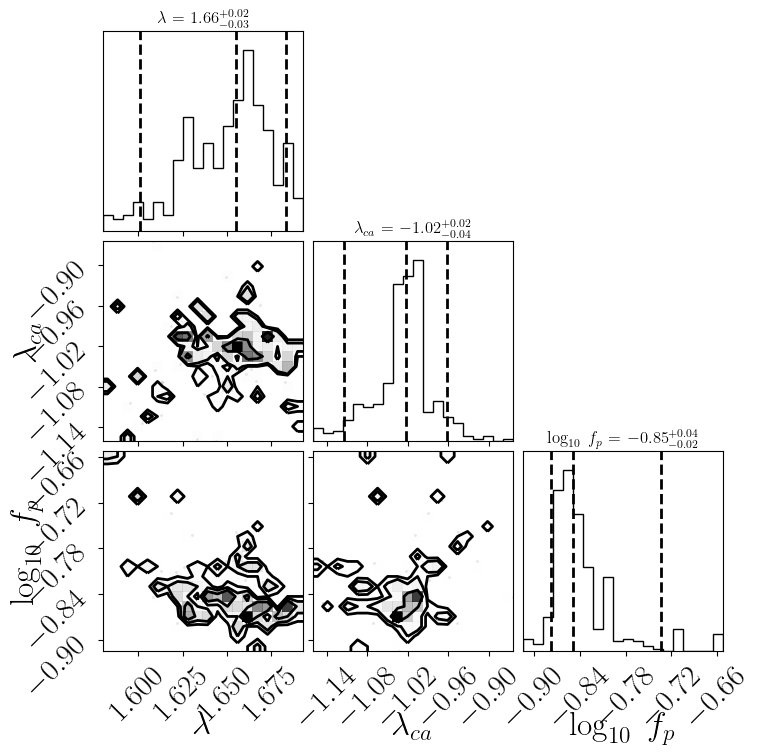

In [24]:
import corner

# plot the constraints
label_names = [r'$\lambda$', r'$\lambda_{ca}$', r'$\log_{10} \ f_{p}$'] 
_ = corner.corner(sampler.flatchain, labels = label_names, quantiles=[0.05, 0.5, 0.95], 
                  levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    show_titles=True, title_kwargs={"fontsize": 12}, bins = 20)

(0.0005501236987934667, 1.0482390980716034)

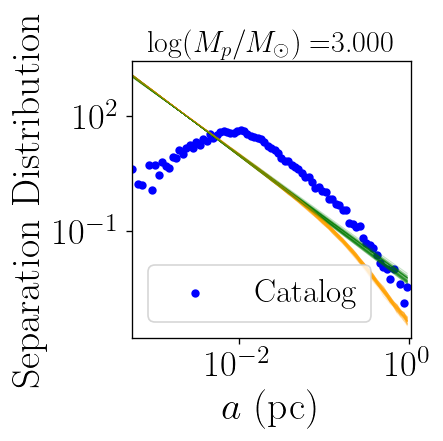

In [26]:
flatchain = sampler.flatchain

# plot distributions with free parameters sampled from posterior
fig = plt.figure(figsize=(3,3), dpi= 120)
ax = fig.add_subplot(111)

# obtain samples from the emcee flat chain and produce plots of separation distributions for each
inds = np.random.randint(len(flatchain), size=100)
for ind in inds:
    sample = flatchain[ind]
    free_params = np.array([sample[0] , sample[1] , sample[2]])
    dn0da = dn0da_fct(mid,sample[0])[n_min:n_max]
    phi0 = dn0da / np.sum(np.diff(bins_data) * dn0da)
    dnda = phi(free_params)[n_min:n_max]
    phi_vec = dnda / np.sum(np.diff(bins_data) * dnda)
    phi_fct = rv_histogram([phi_vec,bins_data])
    phi_fct.rvs(N_data)
    
    #data_theta = np.divide(data_sep, data_dist)
    #data_f = selection_fct(data_theta,theta0,beta)
    
    ax.plot(mid_data, phi_vec, lw = 0.5, alpha=0.1, c='orange')
    ax.plot(mid_data, phi0, lw = 0.5, alpha=0.1, c='green')

# produce density histogram of the data
counts, bins_cat = np.histogram(catalog_data[0,:],bins=bins_data, density = True)
binscenters = np.array([0.5 * (bins_data[i] + bins_data[i+1]) for i in range(len(bins_data)-1)])
ax.scatter(binscenters,counts, c='b', marker='.', label = 'Catalog')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

ax.set_title('$\\log(M_{p}/M_{\\odot}) = $' + str_log_m)
ax.set_xlabel('$a$ (pc)')
ax.set_ylabel('Separation Distribution')
ax.set_xlim([mid[n_min],mid[n_max]])
#ax.set_ylim([np.min(phi_norm_to_cat(free_params)),
#             np.max(phi_norm_to_cat(free_params))])